In [1]:
import copy

import cv2
import numpy as np
import matplotlib.pyplot as plt
# 读入图像并调整大小
img1 = cv2.imread('data/IMG6.jpg')
img2 = cv2.imread('data/IMG5.jpg')
img1 = cv2.resize(img1, dsize=(1024, 512))
img2 = cv2.resize(img2, dsize=(1024, 512))

In [2]:
#   调换颜色通道
def showImage(img):
    img = copy.deepcopy(img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

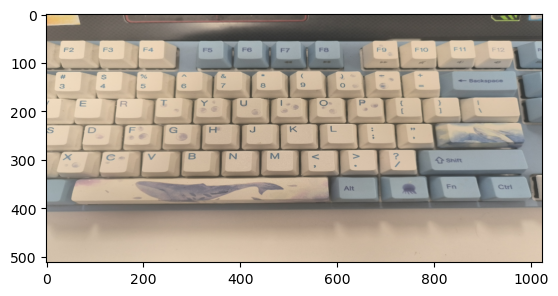

In [3]:
#   展示输入图像
showImage(img1)

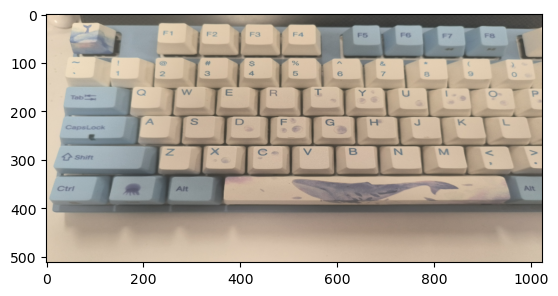

In [4]:
showImage(img2)

In [5]:
# 使用opencv创建SIFT对象
sift = cv2.xfeatures2d.SIFT_create()
# 检测关键点和计算描述符
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

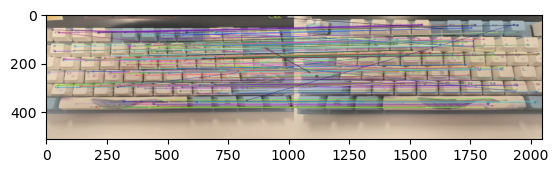

In [6]:
# 匹配关键点
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
# 绘制匹配结果
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)
showImage(img_matches)

In [7]:
import random
#   使用RANSAC算法筛选特征点并得到变换矩阵
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
M1, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
def find_homography(src_pts, dst_pts):
    # Reshape the input points
    src_pts = src_pts.reshape(-1, 2)
    dst_pts = dst_pts.reshape(-1, 2)

    # Construct the A matrix for the homography
    A = []
    for i in range(src_pts.shape[0]):
        x, y = src_pts[i]
        u, v = dst_pts[i]
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
    A = np.asarray(A)

    # Compute the SVD of A
    U, s, Vt = np.linalg.svd(A)
    H = Vt[-1, :].reshape(3, 3)

    # Normalize the homography
    H = H / H[2, 2]

    return H
# 使用 RANSAC 算法计算单应性矩阵
def ransac_homography(src_pts, dst_pts, threshold=5.0, max_iterations=10000):


    best_H = None  # 存储最好的单应性矩阵
    inliers = []   # 存储最好的内点

    for i in range(max_iterations):
        # 从源点和目标点中随机选择4个点
        indices = random.sample(range(src_pts.shape[0]), 4)
        src_sample = src_pts[indices]
        dst_sample = dst_pts[indices]

        # 计算这4个点对应的单应性矩阵
        H = find_homography(src_sample, dst_sample)

        # 使用当前的单应性矩阵计算所有的点
        projected_dst = cv2.perspectiveTransform(src_pts, H)

        # 计算所有点和其对应点之间的距离
        distances = np.sqrt(np.sum(np.square(projected_dst - dst_pts), axis=2))

        # 统计内点个数
        current_inliers = np.where(distances < threshold)[0]

        # 如果当前的内点数大于历史最好内点数，则更新历史最好内点数和单应性矩阵
        if len(current_inliers) > len(inliers):
            best_H = H
            inliers = current_inliers

    return best_H, inliers
M,t = ransac_homography(src_pts, dst_pts, 5.0)
radio = len(t)/src_pts.shape[0]


In [8]:
print("cv2库计算单应性矩阵")
print(M1)
print('内点包含率{:.2%}'.format(np.count_nonzero(mask == 1)/src_pts.shape[0]))

cv2库计算单应性矩阵
[[ 1.09615903e+00  2.80916121e-02  2.84607011e+02]
 [ 1.00491211e-02  1.07220698e+00 -3.91761098e+01]
 [ 1.08803418e-05 -7.16214218e-05  1.00000000e+00]]
内点包含率43.57%


In [9]:
print("自己实验计算单应性矩阵")
print(M)
print('内点包含率{:.2%}'.format(radio))

自己实验计算单应性矩阵
[[ 1.09011513e+00  6.88578940e-02  2.82594595e+02]
 [ 2.19240030e-03  1.09515275e+00 -3.85838212e+01]
 [-9.36778885e-06 -6.05459054e-06  1.00000000e+00]]
内点包含率44.81%
